<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [1]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm



## Retrieving the data

In [2]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [29]:

fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot']

start_date = '2024-12-30'

end_date = '2018-12-30'

In [62]:
#Setting up the function
def get_financial_data(rics, fields, 
                       start_date, end_date):
    rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        #Computing total asset values as a sum of the market capitalization + total debt
        data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [63]:
rics_list = ['AAPL.O', 'META.O']



#### Retrieving the data

In [68]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date)

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [69]:
#Checks on single stocks
print(data.loc['AAPL.O'].head())

                      Close Price  \
Date                                
2024-12-30T00:00:00Z        252.2   
2024-12-27T00:00:00Z       255.59   
2024-12-26T00:00:00Z       259.02   
2024-12-24T00:00:00Z        258.2   
2024-12-23T00:00:00Z       255.27   

                      Shares used to calculate Diluted EPS - Total  \
Date                                                                 
2024-12-30T00:00:00Z                                   15408095000   
2024-12-27T00:00:00Z                                   15408095000   
2024-12-26T00:00:00Z                                   15408095000   
2024-12-24T00:00:00Z                                   15408095000   
2024-12-23T00:00:00Z                                   15408095000   

                      Market Capitalization    Debt - Total     RIC  
Date                                                                 
2024-12-30T00:00:00Z        3463350367230.0  107525000000.0  AAPL.O  
2024-12-27T00:00:00Z        34633503672

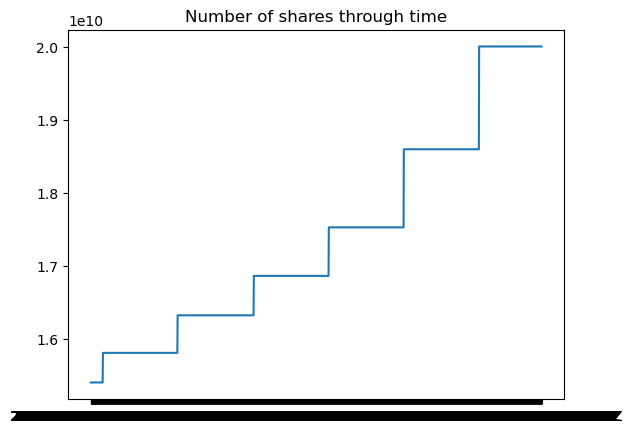

In [120]:
#Plot of outstanding shares 
import matplotlib.pyplot as plt

plt.figure()

plt.title('Number of shares through time')

plt.plot(data.loc['AAPL.O']['Shares used to calculate Diluted EPS - Total'])

plt.show()


### Preparing the functions for the iterative procedure to compute asset values

In [118]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import root_scalar

def black_scholes_equation(V_t, S_t, B, r, T = 1, sigma_V = 0.1):
    """
    Compute the Black-Scholes equity price difference for an array of S_t, B, and r.
    This function is used to find the root for V_t.
    
    Parameters:
    V_t : float
        Asset value to solve for (scalar).
    S_t, B, r : np.array
        Arrays of equity prices, debt face values, and risk-free rates.
    T, sigma_V : float
        Constants: time to maturity and asset volatility.
    t : float
        Current time.

    Returns:
    np.array
        Difference between the calculated equity price and observed equity price S_t.
    """
    # Calculate d_t1 and d_t2 for all elements in S_t, B, and r
    
    d_t1 = (np.log(V_t / B) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d_t2 = d_t1 - sigma_V * np.sqrt(T)
    
    # Black-Scholes formula for equity price
    equity_price = V_t * norm.cdf(d_t1) - B * np.exp(-r * T) * norm.cdf(d_t2)
    
    # Return the difference from observed S_t
    return equity_price - S_t

def invert_black_scholes(S_t, B, r, T=1, sigma_V = 0.1, initial_guess=100):
    """
    Invert the Black-Scholes formula to estimate V_t for arrays of S_t, B, and r.
    
    Parameters:
    S_t, B, r : np.array
        Arrays of observed equity prices, debt face values, and risk-free rates.
    T, sigma_V : float
        Constants: time to maturity and asset volatility.
    t : float
        Current time.
    initial_guess : float
        Initial guess for V_t.

    Returns:
    np.array
        Estimated asset values (V_t) for each input set.
    """
    # Vectorized root finding for each element in S_t, B, and r
    V_t_estimates = []
    for S_t_i, B_i, r_i in zip(S_t, B, r):
        # Initial bracket
        a, b = 1, 400
        f_a = black_scholes_equation(a, S_t_i, B_i, r_i, T, sigma_V)
        f_b = black_scholes_equation(b, S_t_i, B_i, r_i, T, sigma_V)
        
        # Dynamically adjust the bracket until signs are opposite
        while f_a * f_b > 0:
            a /= 2
            b *= 2
            f_a = black_scholes_equation(a, S_t_i, B_i, r_i, T, sigma_V)
            f_b = black_scholes_equation(b, S_t_i, B_i, r_i, T, sigma_V)
        
        # Solve for V_t using root_scalar
        solution = root_scalar(
            black_scholes_equation,
            args=(S_t_i, B_i, r_i, T, sigma_V),
            bracket=[a, b],
            method='brentq'
        )
        V_t_estimates.append(solution.root)
    
    return np.array(V_t_estimates)
"""
# Example Usage
S_t = np.array([50e8, 60e8, 70e8])  # Observed equity prices
B = np.array([100e6, 120e6, 150e6])  # Face values of debt
r = np.array([0.05, 0.04, 0.03])  # Risk-free rates
T = 1.0  # Maturity in years (constant)
t = 0     # Current time
sigma_V = 0.2  # Asset volatility (constant)

V_t_estimated = invert_black_scholes(S_t, B, r, T, sigma_V)
print(f"Estimated Asset Values (V_t): {V_t_estimated}")
"""

'\n# Example Usage\nS_t = np.array([50e8, 60e8, 70e8])  # Observed equity prices\nB = np.array([100e6, 120e6, 150e6])  # Face values of debt\nr = np.array([0.05, 0.04, 0.03])  # Risk-free rates\nT = 1.0  # Maturity in years (constant)\nt = 0     # Current time\nsigma_V = 0.2  # Asset volatility (constant)\n\nV_t_estimated = invert_black_scholes(S_t, B, r, T, sigma_V)\nprint(f"Estimated Asset Values (V_t): {V_t_estimated}")\n'

In [119]:
instrument = 'AAPL.O'

prices = data.loc[instrument]['Close Price']
debt = data.loc[instrument]['Debt - Total'] / 10e9
r = [0.03] * prices.shape[0] 
r = np.array(r)
log_returns = np.log(prices / prices.shift(1)).dropna()
volatility_guess = log_returns.std()

#print(volatility_guess)
#print(prices)
equity_values = (data.loc[instrument]['Shares used to calculate Diluted EPS - Total'] * data.loc[instrument]['Close Price']) / 10e9

value_guess = invert_black_scholes(equity_values, debt, r, sigma_V=volatility_guess)
print(value_guess * 10e9)

[3.99026871e+12 4.04250216e+12 4.09535192e+12 ... 8.22065015e+11
 9.00716729e+11 8.99816710e+11]


In [111]:
equity_values

Date
2024-12-30T00:00:00Z    388.592156
2024-12-27T00:00:00Z      393.8155
2024-12-26T00:00:00Z    399.100477
2024-12-24T00:00:00Z    397.837013
2024-12-23T00:00:00Z    393.322441
                           ...    
2019-01-07T00:00:00Z     73.966612
2019-01-04T00:00:00Z     74.131616
2019-01-03T00:00:00Z      71.09655
2019-01-02T00:00:00Z     78.961721
2018-12-31T00:00:00Z     78.871719
Length: 1510, dtype: Float64

# Function calling

In [ ]:
"""
V = Total company value
K = Liability (strike price)
r = interest rate
sigma = standard deviation
T = Maturity
t = time (a volte non è nemmeno messo ho visto in alcune formule ma nel nostro libro c'è)


V = St+Bt

ST può essere vista come una call option ST = (VT-BT)+
BT come una Put option in pratica BT = B - (B-VT)+

"""

"""'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
FUNCTION TO COMPUTE THE EQUITY VALUE BASED ON MERTON
"""''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def merton_equity(V,K,r,sigma,T,t):

    d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    St = V*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

    return St

"""'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
FUNCTION TO COMPUTE THE DEBT VALUE BASED ON MERTON
"""''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def merton_debt(V,K,r,sigma,T,t):

    d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    Bt = K*np.exp(-r*(T-t))*norm.cdf(d2) + V*(1-norm.cdf(d1))
    
    return Bt
#%% Inputs
r = 0.1        # Risk-free rate (10%)
sigma = 0.2    # Asset volatility (10%)
T = 1          # Maturity time (1 year)
t = 0          # Current time (0 years)

# Compute Equity and Debt
#equity_value = merton_equity(V, K, r, sigma, T, t)
#debt_value = merton_debt(V, K, r, sigma, T, t)

# Validation: Sum of Equity and Debt should equal Total Assets
#validation = equity_value + debt_value

# Output Results
#print(f"Equity Value (S) is: {equity_value:.6f}")
#print(f"Debt Value (B) is: {debt_value:.6f}")
#print(f"Difference between (S+B) and V: {validation:.6f} vs {V}")
#%%
data['Equity'] = data.apply(lambda row: merton_equity(row['Common Equity - Total'], row['Debt - Total'], r, sigma, T, t), axis=1)
data['Debt'] = data.apply(lambda row: merton_debt(row['Common Equity - Total'], row['Debt - Total'], r, sigma, T, t), axis=1)